<b><font size="6">Data-Driven Marketing with Google Merch Store Customer Data</font>

    Notebook by Allison Kelly - allisonkelly42@gmail.com

    Blog post - placeholder

    Presentation - placeholder

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Customer-Lifetime-Value-and-Customer-Attrition-Prediction" data-toc-modified-id="Customer-Lifetime-Value-and-Customer-Attrition-Prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Customer Lifetime Value and Customer Attrition Prediction</a></span><ul class="toc-item"><li><span><a href="#Obtaining-the-data" data-toc-modified-id="Obtaining-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Obtaining the data</a></span></li><li><span><a href="#Cleaning-the-Data" data-toc-modified-id="Cleaning-the-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Cleaning the Data</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li></ul></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Future Work</a></span></li></ul></div>

# Introduction

Leveraging machine learning and AI with the massive amounts of consumer history, web traffic, and product reviews can have a measurable impact on marketing campaigns. By harnessing the power of statistical and analytical tools, patterns untracked by basic dashboards can be unearthed, translating into higher conversion rates over traditional marketing strategies. The following notebook is one such demonstration of this power.

Part one explores customer purchase history on the <a href="https://shop.googlemerchandisestore.com/">Google Merchandise Store.</a> By using machine learning, I will predict the customer lifetime value (CLV) of each customer. This data can then be used to segment ads, email marketing campaigns, and other traditional marketing ventures. I will also predict and measure customer attrition which can be used to develop proactive prevention strategies and increase revenue. 

Part two uses NLP to parse through Google Play store app reviews, conduct sentiment analysis, and classify reviews. The NLP machine learning models can be used to recommend apps and get feedback in realtime to prompt bug fixes and improvements. You'll find this in a separate notebook <b>here.</b> 

Finally, part three will focusing on tracking important metrics and gleaning insights from the Google Analytics demo account for the Google Merchandise Store. Setting benchmarks for KPIs and tracking campaign results are essential to understanding consumer behavior and making informed business decisions. PLACEHOLDER FOR WHERE THIS CAN BE FOUND

# Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import datetime
import numpy as np
import json # for data cleaning
import dill
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Customer Lifetime Value and Customer Attrition Prediction

In marketing, according to <a href="https://en.wikipedia.org/wiki/Customer_lifetime_value">Wikipedia</a>, Customer Lifetime Value (CLV) can be defined as "a prediction of the net profit attributed to the entire future relationship with a customer." CLV is an important metric to track as it can help identify your customer acquisition budget, help your marketing team to segment your customer base, increase retention and satisfaction, etc. CLV is represented as a dollar amount and varies customer to customer. 

<img src="brandwise-clv-bellcurve.gif">

## Obtaining the data

This dataset was derived from the Google Merchandise Store demo account as provided by Google BigQuery on Kaggle. You can find the data <a href="https://www.kaggle.com/c/ga-customer-revenue-prediction">here.</a> 

In [7]:
df = pd.read_csv('train.csv') # loading and checking out the dataset
df.head()

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [8]:
print(df.info())

print('\n\nNumber of individual visitors to the Google Merch Store: ', 
      len(df.fullVisitorId.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
channelGrouping         903653 non-null object
date                    903653 non-null int64
device                  903653 non-null object
fullVisitorId           903653 non-null object
geoNetwork              903653 non-null object
sessionId               903653 non-null object
socialEngagementType    903653 non-null object
totals                  903653 non-null object
trafficSource           903653 non-null object
visitId                 903653 non-null int64
visitNumber             903653 non-null int64
visitStartTime          903653 non-null int64
dtypes: int64(4), object(8)
memory usage: 82.7+ MB
None


Number of individual visitors to the Google Merch Store:  742735


The dataframe is consisted of 903,653 datapoints describing visits to the Google Merch Store with 742,753 unique visitors. Most features consist of objects, though the integers are either dates, times or immutable ID numbers that should be categorized accordingly. 

## Cleaning the Data

In [9]:

def datetime_edits(dataframe):
    
    """This function changes the two columns 
    with dates/times into datetime objects.
    To be used with dataframes with similar
    setup to this one."""
    
    try:
        dataframe.date.astype(str)
        dataframe.date = pd.to_datetime(dataframe.date, 
                                        format='%Y%m%d')
    except:
        print("Your dataframe does not contain a 'date' column.")
        
    try:
        dataframe.visitStartTime = pd.to_datetime(dataframe.visitStartTime, unit='s')
    
    except:
        print("Your dataframe does not containt a 'visitStartTime' column.")
    
    # confirming proper edits were made
    return "Date column:", dataframe.date.dtype, "Time column:", dataframe.visitStartTime.dtype


In [10]:
datetime_edits(df)

('Date column:', dtype('<M8[ns]'), 'Time column:', dtype('<M8[ns]'))

In [11]:
# changing immutable IDs to strings
df.visitId = df.visitId.astype(str)

In [12]:

def unpack_col(df, col):
    
    '''Some column values are dictionary-like strings.
    This function unpacks those values, creating new
    columns for each key that can then be analyzed 
    as separate features. Returns dataframe of 
    unpacked column, not including original column.
    '''
    
    df[col] = df[col].dropna().apply(json.loads)
    unpacked_df = df[col].apply(pd.Series)
        
    return unpacked_df
        
geo_df = unpack_col(df, 'geoNetwork')
totals_df = unpack_col(df, 'totals')


In [13]:
df_expanded = pd.concat([df, geo_df, totals_df], axis=1)

In [14]:
df_expanded.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,...,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,2016-09-02,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{'continent': 'Asia', 'subContinent': 'Western...",1131660440785968503_1472830385,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,...,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
1,Organic Search,2016-09-02,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{'continent': 'Oceania', 'subContinent': 'Aust...",377306020877927890_1472880147,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,...,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
2,Organic Search,2016-09-02,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{'continent': 'Europe', 'subContinent': 'South...",3895546263509774583_1472865386,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
3,Organic Search,2016-09-02,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{'continent': 'Asia', 'subContinent': 'Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
4,Organic Search,2016-09-02,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{'continent': 'Europe', 'subContinent': 'North...",27294437909732085_1472822600,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,NaN,NaN


In [15]:
# Dropping unpacked columns 

df_expanded = df_expanded.drop('geoNetwork', axis=1)
df_expanded = df_expanded.drop('totals', axis=1)

The nested information in the device and trafficSource columns would be necessary for an analysis of ad quality, but we're concerned with what the customer does once they get to the store, not how they get there. We'll drop those columns as well. 

In [18]:
df_expanded = df_expanded.drop(['device', 'trafficSource'], axis=1)

In [19]:
cols = list(df_expanded.columns)

one_variant = []
for col in cols:
    if len(df_expanded[col].unique()) == 1:
        print(df_expanded[col].unique())
        one_variant.append(col)
one_variant

['Not Socially Engaged']
['not available in demo dataset']
['not available in demo dataset']
['not available in demo dataset']
['not available in demo dataset']
['1']


['socialEngagementType',
 'cityId',
 'latitude',
 'longitude',
 'networkLocation',
 'visits']

Columns with no variation in value will be dropped. Some columns in a full dataset such as language could be relevant to CLV, but since we don't have that information available through the Google Demo Account, we'll remove those columns. 

In [21]:
df_expanded = df_expanded.drop(one_variant, axis=1)

Because our unique customer identifier is tied to 'fullVisitorId' and 'visitStartTime' describes the frequency (or lacktherof) of visits to the store, we can safely remove 'sessionId' and 'visitId'.

In [23]:
df_expanded = df_expanded.drop(['visitId', 'sessionId'], axis=1)

Columns 'region,' 'metro,' and 'city' may have an impact on whether or not a customer will spend in the future and how much due to income levels and cost of living, however most of the information in these categories is not available. We'll drop these columns for this project, though you may consider leaving them if other datasets give a more detailed look into the customers location. We can also drop 'continent' and 'subcontinent' because the country names themselves give us that information inherently. 

In [24]:
df_expanded = df_expanded.drop(['region', 'metro', 'city', 'continent', 'subContinent' ], axis=1)

In [25]:
# Removing parentheses around "Other" channel group
df_expanded.channelGrouping = df_expanded.channelGrouping.str.strip('()')

Finally, we'll drop the 'networkDomain' column as it doesn't pertain to the prediction of CLV. 

In [29]:
df_expanded.drop('networkDomain', axis=1, inplace=True)

In [33]:
df_expanded.isna().any()

channelGrouping       False
date                  False
fullVisitorId         False
visitNumber           False
visitStartTime        False
country               False
hits                  False
pageviews              True
bounces                True
newVisits              True
transactionRevenue     True
dtype: bool

In [26]:
# Replacing a variant of NaN with 'Unknown'
df_expanded = df_expanded.replace('(not set)', 'Unknown')

In [47]:
nan_cols = ['pageviews', 'bounces', 'newVisits', 'transactionRevenue']
for col in nan_cols: 
    
    print(f'{col} NaN: ', df_expanded[col].isnull().sum())
    print(f'{col} datatype: ', df_expanded[col].dtype, '\n')

pageviews NaN:  100
pageviews datatype:  object 

bounces NaN:  453023
bounces datatype:  object 

newVisits NaN:  200593
newVisits datatype:  object 

transactionRevenue NaN:  892138
transactionRevenue datatype:  object 



Each of the columns that contain null values are related to the customer's behavior once on the site. We can change the NaNs to 0 to indicate no pages were viewed, the customer did not bounce, the customer has been to the merch store previously, and the customer did not purchase from the store. We also need to correct the datatype of 'transactionRevenue' from object to float. 

In [48]:
df_expanded.fillna('0', inplace=True)

In [52]:
df_expanded.transactionRevenue = df_expanded.transactionRevenue.astype('float')

In [53]:
for col in df_expanded.columns:
    print(df_expanded[col].value_counts().head())

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Name: channelGrouping, dtype: int64
2016-11-28    4807
2016-11-15    4685
2016-11-14    4466
2016-11-30    4435
2016-10-26    4375
Name: date, dtype: int64
824839726118485274     205
1957458976293878100    205
1856749147915772585    151
3608475193341679870    149
7634897085866546110    131
Name: fullVisitorId, dtype: int64
1    703060
2     92548
3     35843
4     19157
5     11615
Name: visitNumber, dtype: int64
2017-04-25 18:49:35    8
2016-11-05 11:38:24    6
2017-01-17 10:43:22    6
2016-12-10 11:32:05    6
2017-05-09 23:56:39    5
Name: visitStartTime, dtype: int64
United States     364744
India              51140
United Kingdom     37393
Canada             25869
Vietnam            24598
Name: country, dtype: int64
1    446754
2    137952
3     70402
4     42444
5     30939
Name: hits, dtype: int64
1    452522
2    143770
3     73835
4     45192
5     33411


In [54]:
# df_expanded.to_csv('cleaned_df.csv', index=False)

## Exploratory Data Analysis

In [55]:
df = pd.read_csv('cleaned_df.csv')
df.head()

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,country,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,2016-09-02 00:00:00,1131660440785968503,1,2016-09-02 15:33:05,Turkey,1,1,1,1,0.0
1,Organic Search,2016-09-02 00:00:00,377306020877927890,1,2016-09-03 05:22:27,Australia,1,1,1,1,0.0
2,Organic Search,2016-09-02 00:00:00,3895546263509774583,1,2016-09-03 01:16:26,Spain,1,1,1,1,0.0
3,Organic Search,2016-09-02 00:00:00,4763447161404445595,1,2016-09-03 05:40:13,Indonesia,1,1,1,1,0.0
4,Organic Search,2016-09-02 00:00:00,27294437909732085,2,2016-09-02 13:23:20,United Kingdom,1,1,1,0,0.0


In [56]:
df.describe()

,visitNumber,hits,pageviews,bounces,newVisits,transactionRevenue
count,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,9.036530e+05
mean,2.264897,4.596538,3.849338,0.498676,0.778020,1.704273e+06
std,9.283735,9.641437,7.025002,0.499999,0.415578,5.277866e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00
50%,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000e+00
75%,1.000000,4.000000,4.000000,1.000000,1.000000,0.000000e+00
max,395.000000,500.000000,469.000000,1.000000,1.000000,2.312950e+10


In [58]:
print('Our timeline begins: ', df.visitStartTime.min(), 'and ends: ', df.visitStartTime.max())

Our timeline begins:  2016-08-01 07:00:12 and ends:  2017-08-02 06:59:53


Our data consists of one year (August 2016 - 2017) of customer data. 

channelGrouping
Affiliates        AxesSubplot(0.125,0.125;0.775x0.755)
Direct            AxesSubplot(0.125,0.125;0.775x0.755)
Display           AxesSubplot(0.125,0.125;0.775x0.755)
Organic Search    AxesSubplot(0.125,0.125;0.775x0.755)
Other             AxesSubplot(0.125,0.125;0.775x0.755)
Paid Search       AxesSubplot(0.125,0.125;0.775x0.755)
Referral          AxesSubplot(0.125,0.125;0.775x0.755)
Social            AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

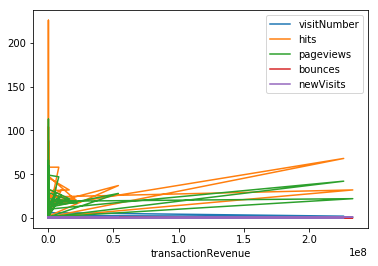

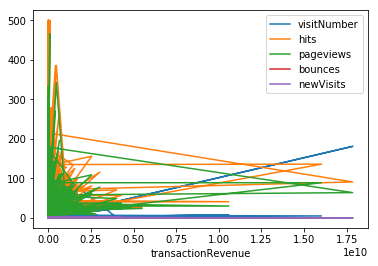

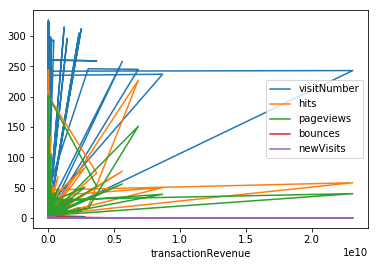

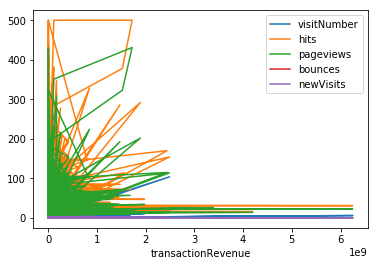

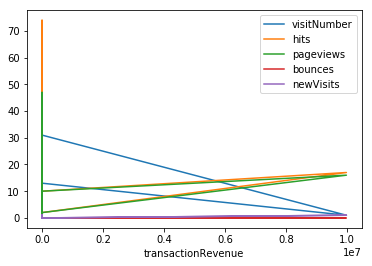

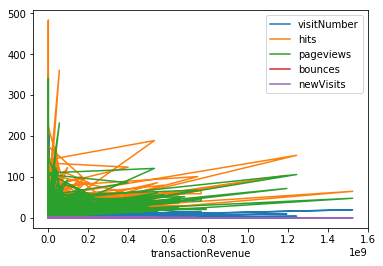

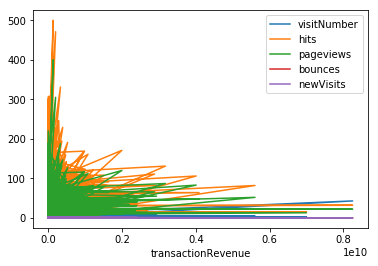

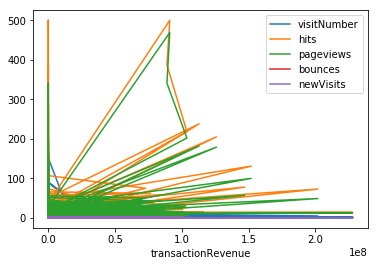

In [59]:
df.groupby('channelGrouping').plot('transactionRevenue')

# Future Work